# Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mnist_get_images import get_images

%matplotlib inline

In [2]:
mnist_path = './mnist_raw/'

In [3]:
X_train_num, y_train_num, X_test_num, y_test_num = get_images(mnist_path)
# Testing data
print(f'Dimensiones datos de entrenamiento: {X_train_num.shape} \nDimensiones datos de prueba: {X_test_num.shape}')

Dimensiones datos de entrenamiento: (60000, 28, 28) 
Dimensiones datos de prueba: (10000, 28, 28)


## Images to vectors in float32

In [4]:
X_train = X_train_num[:50_000].reshape(50_000, -1).astype(np.float32)/255
y_train = y_train_num[:50_000].reshape(50_000, 1)

x_validation = X_train_num[50_000:].reshape(10_000, -1).astype(np.float32)/255
y_validation = y_train_num[50_000:].reshape(10_000, 1)

X_test = X_test_num.copy().reshape(10_000, -1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10_000, 1)

# Testing set
print(f'X_train: {X_train.max()} \n')

# Shape
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')

print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: 1.0 

X_train: (50000, 784)
y_train: (50000, 1)
X_test: (10000, 784)
y_test: (10000, 1)


## Graph image

In [5]:
def plot_img_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen mostrada corresponde a un: [8]


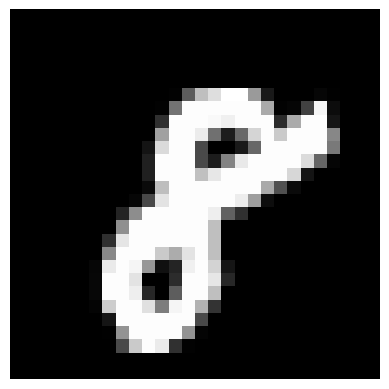

In [6]:
rand_idx = np.random.randint(len(y_test))
print(f'La imagen mostrada corresponde a un: {y_test[rand_idx]}')
plot_img_number(X_test_num[rand_idx])

## Mini-Batches 

2 layers 200-10

In [7]:
def create_minibatches(mb_size, x, y, shuffle=True):
    '''
    x = (number of samples, 784)
    y = (nuumber of samples, 1)
    '''
    assert x.shape[0] == y.shape[0], 'Error en la cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arrange(total_data)
        np.random.shuffle(idxs)
        x, y = x[idxs], y[idxs]

    return ((x[i:i + mb_size], y[i:i + mb_size]) for i in range(0, total_data, mb_size))

## Init parameters

In [8]:
def init_parameters(input_size, neurons):
    '''
    input_size = (input elements, 784)
    neurons = list[200, 10] amount of neurons in every layer
    '''
    w1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0], 1))

    w2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))

    return {'w1' : w1, 'b1' : b1, 'w2' : w2, 'b2' : b2}

In [9]:
parameters = init_parameters(28*28, [200, 10])
print(f'{parameters["w1"].shape}')
print(f'{parameters["w2"].shape}')
print(f'{parameters["b2"].shape}')

(200, 784)
(10, 200)
(10, 1)


In [10]:
def relu(x):
    return np.maximum(0, x)

In [11]:
def scores(x, parameters, act_function):
    ''''
    X has shape (number of pixels, number of samples)
    '''
    z1 = parameters['w1'] @ x + parameters['b1']
    a1 = act_function(z1)  # Return action function
    z2 = parameters['w2'] @ a1 + parameters['b2']

    return z2, z1, a1

In [12]:
scores, z1, a1, = scores(X_train[:64].T, parameters, relu)

In [13]:
X_train[:64].T.shape

(784, 64)

In [14]:
def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0)
    probs = exp_scores / sum_exp_scores
    return probs

In [15]:
def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y. squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    return probs, cost

In [16]:
y_train.squeeze()[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [21]:
def backward(probs, x, y, z1, a1, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # y-hat - y
    dz2 = probs.copy()

    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis=1, keepdims=True) / batch_size
    da1 = parameters['w2'].T @ dz2

    dz1 = da1.copy()
    dz1[z1 <= 0] = 0

    dW1 = dz1 @ x
    db1 = np.sum(dz1, axis=1, keepdims=True)

    assert parameters['w1'].shape == dW1.shape, 'W1 shape mismatch'
    assert parameters['w2'].shape == dW2.shape, 'W2 shape mismatch'
    assert parameters['b1'].shape == db1.shape, 'b1 shape mismatch'
    assert parameters['b2'].shape == db2.shape, 'b1 shape mismatch'

    grads = {'w1': dW1, 'b1': db1, 'w2': dW2, 'b2': db2}

    return grads

In [22]:
y_hat, cost = x_entropy(scores, y_train[:64])
y_hat.shape

(10, 64)

In [23]:
grads = backward(y_hat, X_train[:64], y_train[:64], z1, a1, parameters)